In [1]:
import initialize_notebook

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

import io
from ams import config
from sklearn.preprocessing import StandardScaler
import pandas_datareader.data as web
import math
import os
import datetime as dt
import sys
from pathlib import Path
from typing import Dict

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, Row, StructField, DoubleType, ArrayType, StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from ams.config import constants
from ams.services import file_services
from ams.services import spark_service
from ams.utils import sentiment
from pyspark.storagelevel import StorageLevel

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Miniconda3\envs\alpha_media_signal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


Setting up logging...
Will use logging path: C:\Users\Chris\workspaces\data\logs\alpha_media_signal


In [2]:
# import findspark

# findspark.init()
spark = spark_service.get_or_create('learning_prep')
# spark.stop()
# spark = spark_service.get_or_create('learning_prep')

In [3]:
twitter_folder = 'twitter'

tweet_sent_overflow_archive = [
    "tweet_sent_2020-09-14_01-54-46-424.27", "tweet_sent_2020-09-16_04-20-22-347.55", 
    "tweet_sent_2020-09-18_13-56-57-859.2", "tweet_sent_2020-09-18_22-23-53-311.06", 
    "tweet_sent_2020-09-20_12-55-15-934.3", "tweet_sent_2020-09-26_09-31-41-445.65", 
    "tweet_sent_2020-09-26_14-37-22-544.29", "tweet_sent_2020-09-28_21-45-23-139.81", 
    "tweet_sent_2020-10-10_08-37-57-420.11", "tweet_sent_2020-10-12_17-01-57-220.74"   
]

tweet_sent_orig_archive = [
    "tweet_sent_2020-10-17_10-47-14-355.0", "tweet_sent_2020-10-21_20-42-38-339.38",
    "tweet_sent_2020-10-25_17-01-21-632.26"
]

In [4]:
%%time

senti_dataframes = []

file_paths = [Path(constants.OVERFLOW_DATA_PATH, twitter_folder, "sent_drop", "archive", t) for t in tweet_sent_overflow_archive]

file_paths += [Path(constants.DATA_PATH, twitter_folder, "sent_drop", t) for t in tweet_sent_orig_archive]

for f in file_paths:
    print(str(f))
    df = spark.read.csv(str(f), header=True)
    print(f"loaded {df.count()}")
    senti_dataframes.append(df) 

D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-14_01-54-46-424.27
loaded 2606202
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-16_04-20-22-347.55
loaded 312411
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-18_13-56-57-859.2
loaded 1376331
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-18_22-23-53-311.06
loaded 690703
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-20_12-55-15-934.3
loaded 909703
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-26_09-31-41-445.65
loaded 623898
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-26_14-37-22-544.29
loaded 463726
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-09-28_21-45-23-139.81
loaded 724522
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-10-10_08-37-57-420.11
loaded 2882840
D:\workspaces\data\twitter\sent_drop\archive\tweet_sent_2020-10-12_17-01-57-220.74
loaded 470770
C:\Users\Chris\workspaces\dat

In [5]:
%%time

from functools import reduce
from pyspark.sql import DataFrame

df = reduce(DataFrame.unionByName, senti_dataframes)
senti_dataframes = None

df_red = df
# df.persist(StorageLevel.DISK_ONLY)
# df = None

Wall time: 161 ms


In [6]:
%%time

from ams.utils import date_utils
from pyspark.sql import types as T
from datetime import datetime

def add_timestamp(df):
    twitter_format = date_utils.TWITTER_LONG_FORMAT 
    def udf_wrapper(date_string: str):
        return int(datetime.strptime(date_string, twitter_format).timestamp())

    parse_udf = F.udf(udf_wrapper, T.IntegerType())

    print(f'Count: {df.count()}')

    df = df.withColumn('created_at_timestamp', parse_udf(F.col('created_at')))
    
    return df

df_ts = add_timestamp(df_red)

Count: 13897423
Wall time: 20.8 s


In [7]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from ams.utils import date_utils

def get_fave_cols(df):
    return df.select(*["created_at",
                     "created_at_timestamp",
                     "user_screen_name",
                     "favorite_count",
                     "in_reply_to_screen_name",
                     "user_verified",
                     "metadata_result_type",
                     "user_listed_count",
                     "user_time_zone",
                     "user_has_extended_profile",
                     "in_reply_to_status_id",
                     "user_statuses_count",
                     "user_protected",
                     "user_is_translation_enabled",
                     "user_location",
                     "lang",
                     "user_geo_enabled",
                     "place_country",
                     "place_name",
                     "possibly_sensitive",
                     "user_friends_count",
                     "retweet_count",
                     "user_follow_request_sent",
                     "user_followers_count",
                     "f22_ticker",
                     "f22_has_cashtag",
                     "f22_ticker_in_text",
                     "f22_num_other_tickers_in_tweet",
                     "f22_sentiment_pos",
                     "f22_sentiment_neu",
                     "f22_sentiment_neg",
                     "f22_sentiment_compound"])

df_winn = get_fave_cols(df_ts)
# df_ts = None

In [8]:
df_has_time = df_winn.where(F.col('created_at_timestamp').isNotNull())
# df_winn.persist(StorageLevel.DISK_ONLY)
# df_winn = None

In [9]:
%%time

from ams.utils import twitter_utils
from pyspark.sql import functions as F, types as T
from ams.utils.date_utils import TZ_AMERICA_NEW_YORK, STANDARD_DAY_FORMAT
import pytz


def convert_to_date_string(utc_timestamp: int):
    dt_utc = datetime.fromtimestamp(utc_timestamp)
    dt_nyc = dt_utc.astimezone(pytz.timezone(TZ_AMERICA_NEW_YORK))
    return dt_nyc.strftime(STANDARD_DAY_FORMAT)

def chunk_for_udf(df: DataFrame):
    parse_udf = F.udf(convert_to_date_string, T.StringType())

    chunk_size = 6
    print(f"Will split into {chunk_size} chunks...")
    
    split_arr = [1.] * chunk_size
    all_dfs = df.randomSplit(split_arr)

    new_dfs = []
    for df in all_dfs:
        df = df.withColumn('date', parse_udf(F.col('created_at_timestamp')))
        print(df.count())
        new_dfs.append(df)

    all_dfs = None

    return reduce(DataFrame.union, new_dfs)
    
df_dated = chunk_for_udf(df_winn)

Will split into 6 chunks...
2315902
2315588
2317688
2315460
2315719
2317066
Wall time: 11min 57s


In [10]:
%%time

df_sample = df_dated.sample(fraction=.0001)
df_sample.cache()

print(df_sample.count())

1361
Wall time: 22min 32s


Wall time: 4.28 s


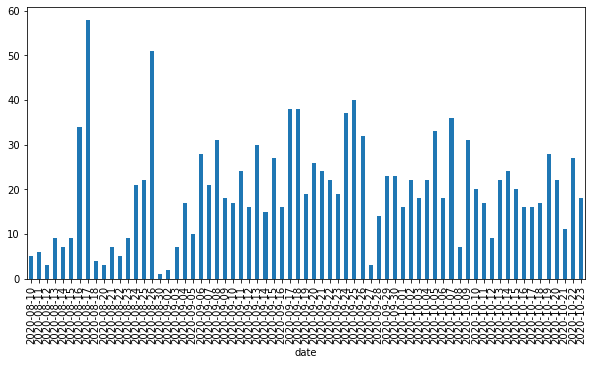

In [11]:
%%time

df_pd = df_sample.toPandas().sort_values('date', inplace=False)

day_groups = df_pd.groupby(df_pd['date'])['date'].count()

day_groups.plot(kind='bar',figsize=(10,5),legend=None)

In [12]:
%%time

df_time_converted = df_dated.withColumn('user_followers_count', F.col('user_followers_count').cast(T.IntegerType())).withColumn('f22_sentiment_compound', F.col('f22_sentiment_compound').cast(T.FloatType()))

df_has_scores = df_time_converted.where(F.col('user_followers_count') > 0).where(F.col('f22_sentiment_compound') != 0)

df_com_score = df_has_scores.withColumn('f22_compound_score', F.col('user_followers_count') * F.col('f22_sentiment_compound'))
print(f'Has followers and compound score: {df_has_scores.count()}')

Has followers and compound score: 8705788
Wall time: 12min 7s


In [13]:
%%time

from ams.services import dataframe_services

tag = 'learning_prep_drop'

sent_drop_path = Path(constants.DATA_PATH, twitter_folder, tag)

dataframe_services.persist_dataframe_as_csv(df=df_com_score, output_drop_folder_path=sent_drop_path, prefix=tag, num_output_files=1)

C:\Users\Chris\workspaces\data\twitter\learning_prep_drop\learning_prep_drop_2020-10-25_18-00-45-267.63
Wall time: 23min 36s
